<a href="https://colab.research.google.com/github/gurramt/iiith_python/blob/main/242007_U2_MH2_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

## Problem Statement

Perform customer segmentation using bank data into distinct categories based on their behavioral patterns

## Learning Objectives

At the end of the experiment, you will be able to:

* Understand clustering
* Find groups or clusters using K-means algorithm
* Visualize the high-dimensional data to low-dimensional data (2D) by applying t-SNE algorithm

In [ ]:
#@title  Mini Hackathon Walkthrough
from IPython.display import HTML

HTML("""<video width="854" height="480" controls>
  <source src="https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/Walkthrough/Customer_Segmentation.mp4" type="video/mp4">
</video>
""")

## Domain Information

- **Customer segmentation** refers to the process of dividing a set of potential customers into groups (or segments) based on shared attributes, interests, and behaviors.
- One of the key pain points for bank marketing team is to know their customers and identify their needs.
- For this mini-hackathon, we will use the popular **K-Means clustering** algorithm to segment customers based on their behavior from the bank data. The basic concept is that consumers who share common traits would respond to marketing communication in a similar way so that the bank marketing team can reach out to each group in a relevant and effective way.

## Dataset

### Description

The dataset chosen for this mini hackathon is the behavior of customers in the bank for 6 months, this dataset is made up of 13 features.

**Attribute Information**

- **CUSTID:** Identification of Credit Cardholder
- **BALANCE:** Balance amount left in customer's account to make purchases
- **PURCHASES:** Amount of purchases made from the account
- **INSTALLMENTS_PURCHASES:** Amount of purchase done in installment
- **CASH_ADVANCE:** Cash in advance given by the user
- **PURCHASES_FREQUENCY:** How frequently the Purchases are being made score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
- **CASH_ADVANCE_FREQUENCY:** How frequently the cash in advance being paid
- **CASH_ADVANCE_TRX:** Number of Transactions made with "Cash in Advance"
- **CREDIT_LIMIT:** Limit of Credit Card for user
- **PAYMENTS:** Amount of Payment done by a user
- **MINIMUM_PAYMENTS:** Minimum amount of payments made by a user
- **PRC_FULL_PAYMENT:** Percent of full payment paid by a user
- **TENURE:** Tenure of credit card service for user

**Note:** The currency values mentioned above are in "dollars"

## Grading = 10 Marks

## Setup Steps

In [ ]:
#@title Run this cell to complete the setup for this Notebook

from IPython import get_ipython
ipython = get_ipython()

notebook="U2_MH2_Customer_Segmentation" #name of the notebook
Answer = "This notebook is graded by mentors on the day of hackathon"
def setup():
    ipython.magic("sx wget https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/Marketing_data_clustering.csv")
    print ("Setup completed successfully")
    return

setup()

Setup completed successfully


### Importing Required Packages

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## **Stage 1:** Data Pre-Processing (2 Marks)

- Replace the missing values in any other column appropriately with mean / median / mode.

  Hint: Use pandas [fillna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html) function to replace the missing values

- Perform correlation on the data features and remove highly correlated features from the data
  
  Hint: Use pandas [corr](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html)

- Drop any unwanted columns
  
  Hint: Use pandas [drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html)

- Perform `StandardScaler()` on the data features
  
  Hint: Use Sklearns [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)



In [ ]:
# Getting information about the dataset
def explore_dataframe(df, name):
    print(f"============== {name} info =========================")
    print("Columns:", df.columns.tolist()) # Convert to list for better readability
    print("Shape:", df.shape)
    print("Data Types:", df.dtypes)
    #print("Descriptive Statistics:\n", df.describe())
    print("First 5 rows:\n", df.head())
    print("Missing Values:\n", df.isnull().sum())
    print("-" * 40) # Add a separator for clarity


In [ ]:
def remove_Highly_Correlated(df, bar=0.9):
  # Creates correlation matrix
  corr = df.corr()
  #print("Correlation Matrix:\n", corr) # Print the correlation matrix

  # Set Up Mask To Hide Upper Triangle
  mask = np.triu(np.ones_like(corr, dtype=bool))
  tri_df = corr.mask(mask)

  # Finding features with correlation value more than specified threshold value (bar=0.9)
  highly_cor_col = [col for col in tri_df.columns if any(tri_df[col] > bar )]
  print("length of highly correlated columns",len(highly_cor_col), highly_cor_col)

  #Drop the highly correlated columns
  reduced_df = df.drop(highly_cor_col, axis = 1)
  print("shape of data",df.shape,"shape of reduced data",reduced_df.shape)
  return reduced_df

In [ ]:
df = pd.read_csv("Marketing_data_clustering.csv")
explore_dataframe(df, "Marketing data")

============== Marketing data info =========================
Columns: ['CUST_ID', 'BALANCE', 'PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']
Shape: (2994, 13)
Data Types: CUST_ID                    object
BALANCE                   float64
PURCHASES                 float64
INSTALLMENTS_PURCHASES    float64
CASH_ADVANCE              float64
PURCHASES_FREQUENCY       float64
CASH_ADVANCE_FREQUENCY    float64
CASH_ADVANCE_TRX            int64
CREDIT_LIMIT              float64
PAYMENTS                  float64
MINIMUM_PAYMENTS          float64
PRC_FULL_PAYMENT          float64
TENURE                      int64
dtype: object
First 5 rows:
   CUST_ID      BALANCE  PURCHASES  INSTALLMENTS_PURCHASES  CASH_ADVANCE  \
0  C10001    40.900749      95.40                    95.4       0.00000   
1  C10005   817.714335      16.00                     

In [ ]:
#Step1: Replace the missing values in any other column appropriately with mean / median / mode.
#Only MINIMUM_PAYMENTS has missing values.
#It is recommended to use median value to fill in missing values of payments.

median_value = df['MINIMUM_PAYMENTS'].mean()
print(median_value)
df['MINIMUM_PAYMENTS'].fillna(median_value, inplace=True)

print("Checking null values after filling in the details", df.isnull().sum().sum())

df.drop('CUST_ID', axis=1, inplace=True)

# Since value in TENURE is constant, dropping this column as well.
unique_tenure_values = df['TENURE'].unique()
print("Unique values in 'TENURE' column:", unique_tenure_values)
df.drop("TENURE", inplace=True, axis=1)

#step2: Perform correlation on the data features and remove highly correlated features from the data


469.31973318641764
Checking null values after filling in the details 0
Unique values in 'TENURE' column: [12]


<Axes: >

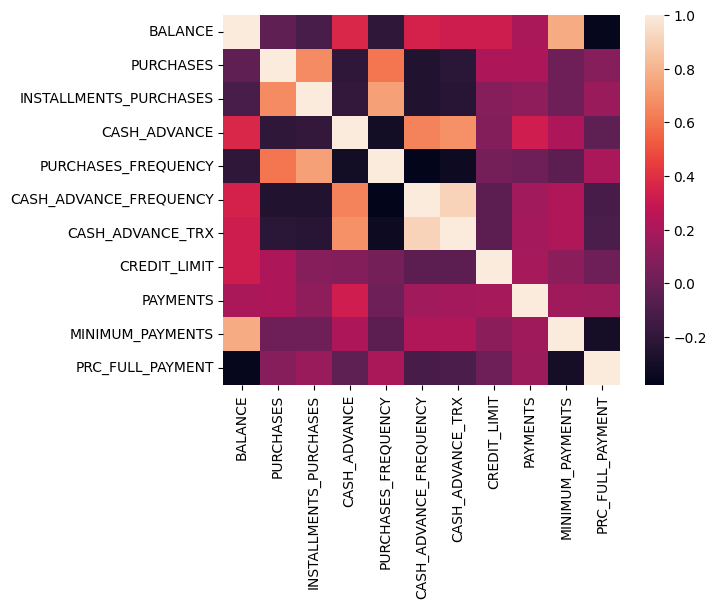

In [ ]:
import seaborn as sns
sns.heatmap(df.corr(numeric_only=True))

In [ ]:
reduced_df = remove_Highly_Correlated(df)

length of highly correlated columns 1 ['CASH_ADVANCE_FREQUENCY']
shape of data (2994, 11) shape of reduced data (2994, 10)


In [ ]:
print(reduced_df.head())
print(reduced_df.shape)

       BALANCE  PURCHASES  INSTALLMENTS_PURCHASES  CASH_ADVANCE  \
0    40.900749      95.40                    95.4       0.00000   
1   817.714335      16.00                     0.0       0.00000   
2  1823.652743     436.20                   436.2       0.00000   
3  1014.926473     861.49                   200.0       0.00000   
4  2772.772734       0.00                     0.0     346.81139   

   PURCHASES_FREQUENCY  CASH_ADVANCE_TRX  CREDIT_LIMIT    PAYMENTS  \
0             0.166667                 0        1000.0  201.802084   
1             0.083333                 0        1200.0  678.334763   
2             1.000000                 0        2300.0  679.065082   
3             0.333333                 0        7000.0  688.278568   
4             0.000000                 1        3000.0  805.647974   

   MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  
0        139.509787               0.0  
1        244.791237               0.0  
2        532.033990               0.0  
3        311.963

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(reduced_df)
#Since the fit_transform() method returns a NumPy array, this line converts the scaled data back into a pandas DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=reduced_df.columns)
X_scaled.head()
X_scaled.shape

(2994, 10)

## **Stage 2:** K Means (3 Marks)

- Find the right number of clusters to be chosen using the elbow method
  
- Perform K-Means on the chosen optimal number of clusters

  **Hint:** Refer to this [link](https://towardsdatascience.com/clustering-algorithms-for-customer-segmentation-af637c6830ac) for finding the k-clusters using elbow method and applying kmeans

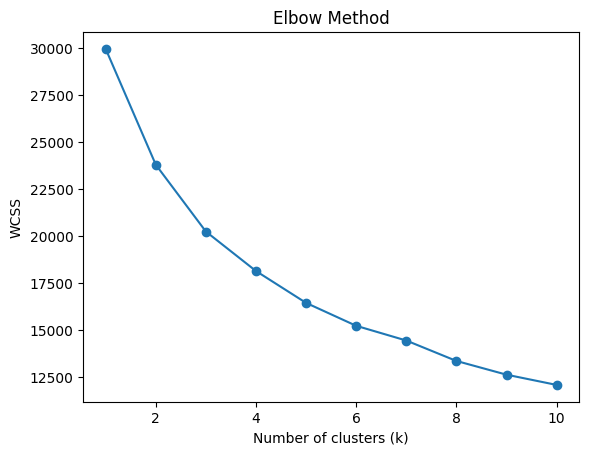

In [ ]:
# YOUR CODE HERE

wcss = []

# Try cluster numbers from 1 to 10
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.show()


In [ ]:
#!pip install kneed

Optimal number of clusters: 4


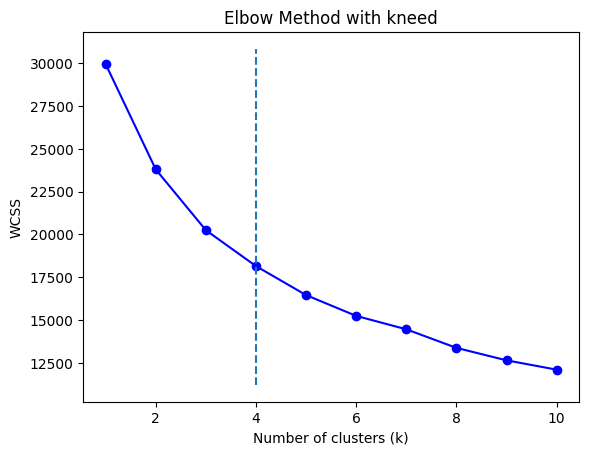

In [ ]:
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.pyplot as plt

wcss = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # inertia_ is WCSS in sklearn

# Use KneeLocator to find the elbow point
kl = KneeLocator(
    K, wcss, curve="convex", direction="decreasing"
)

print(f"Optimal number of clusters: {kl.elbow}")

# Plot
plt.plot(K, wcss, 'bo-')
plt.vlines(kl.elbow, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow Method with kneed")
plt.show()

For n_clusters = 2, the silhouette score is 0.2047
For n_clusters = 3, the silhouette score is 0.2210
For n_clusters = 4, the silhouette score is 0.2504
For n_clusters = 5, the silhouette score is 0.1928
For n_clusters = 6, the silhouette score is 0.2126
For n_clusters = 7, the silhouette score is 0.2120
For n_clusters = 8, the silhouette score is 0.2149
For n_clusters = 9, the silhouette score is 0.1676
For n_clusters = 10, the silhouette score is 0.1972


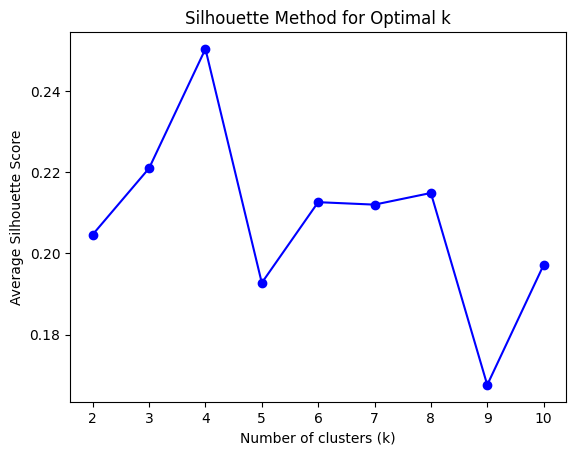

Optimal number of clusters (k): 4


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Example: X is your feature matrix (scaled!)
range_n_clusters = list(range(2, 11))  # k must be >=2 for silhouette

silhouette_avg = []

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, cluster_labels)
    silhouette_avg.append(score)
    print(f"For n_clusters = {k}, the silhouette score is {score:.4f}")

# Plot the scores to see the best k
plt.plot(range_n_clusters, silhouette_avg, 'bo-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Average Silhouette Score")
plt.title("Silhouette Method for Optimal k")
plt.show()

# Best k
optimal_k = range_n_clusters[silhouette_avg.index(max(silhouette_avg))]
print(f"Optimal number of clusters (k): {optimal_k}")

In [ ]:
# prompt: Perform K-Means on the chosen optimal number of clusters

# From the elbow plot, the optimal number of clusters appears to be 4.
optimal_k = 4

# Perform K-Means on the chosen optimal number of clusters using the scaled data before adding the cluster column
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_scaled.drop('Cluster', axis=1))

# Add the cluster labels to the scaled dataframe
X_scaled['Cluster'] = kmeans.labels_

#print("DataFrame with cluster labels:")
#print(df.head())

print(kmeans.cluster_centers_)

[[-5.21805054e-02  1.16751550e+00  1.32020908e+00 -3.92062614e-01
   1.15263691e+00 -4.18690353e-01  1.50486971e-01  2.66028401e-01
   1.65780805e-01 -2.29072542e-01  2.10942375e-14]
 [-3.12684056e-01 -4.06689503e-01 -4.85890742e-01 -3.86188114e-01
  -4.21297113e-01 -2.70563948e-01 -3.06778651e-01 -4.34460481e-01
  -3.14304601e-01 -3.02151255e-01  1.02089783e+00]
 [-1.03222663e+00  2.22499286e-01  3.85298239e-01 -3.73998718e-01
   7.86761153e-01 -4.96723159e-01  7.63182869e-02 -3.15134921e-02
  -8.74148485e-01  2.50674992e+00  3.00000000e+00]
 [ 9.95369919e-01 -4.46839391e-01 -5.11553132e-01  1.18121562e+00
  -6.26267809e-01  1.05081776e+00  3.69242305e-01  5.28412662e-01
   7.36705454e-01 -2.32032347e-01  2.00000000e+00]]


In [ ]:
X_scaled.head()

,BALANCE,PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,CASH_ADVANCE_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,Cluster
0,-1.133600,-0.632613,-0.317151,-0.641837,-0.605044,-0.733337,-0.904793,-0.881709,-0.943177,-0.414442,3
1,-0.376303,-0.811660,-0.689393,-0.641837,-0.828798,-0.733337,-0.822240,-0.197005,-0.642098,-0.414442,3
2,0.604361,0.135888,1.012616,-0.641837,1.632485,-0.733337,-0.368198,-0.195955,0.179348,-0.414442,0
3,-0.184046,1.094914,0.090987,-0.641837,-0.157540,-0.733337,1.571799,-0.182717,-0.450001,-0.414442,0
4,1.529635,-0.847739,-0.689393,-0.108188,-1.052550,-0.320706,-0.079263,-0.014075,1.488914,-0.414442,2


## **Stage 3:** Apply **TSNE** with 2 components (n_components = 2) and visualize the clusters (3 Marks)

Hint: Use Sklearns [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

**Note:** Produce a visualization with distinctly isolated clusters and It is not necessary to plot the centroids



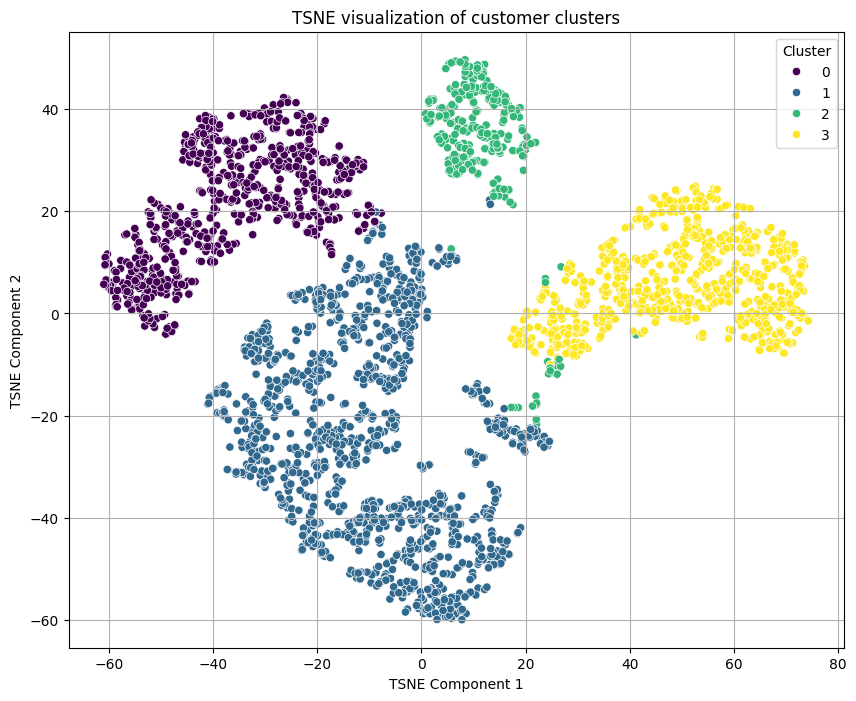

In [ ]:
# prompt: Apply TSNE with 2 components (n_components = 2) and visualize the clusters

import pandas as pd
import matplotlib.pyplot as plt
# Apply TSNE with 2 components
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Create a DataFrame from the TSNE results
tsne_df = pd.DataFrame(data = X_tsne, columns = ['TSNE_component_1', 'TSNE_component_2'])

# Add the cluster labels
tsne_df['Cluster'] = X_scaled['Cluster']

# Visualize the clusters using TSNE components
plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE_component_1', y='TSNE_component_2', hue='Cluster', data=tsne_df, palette='viridis')
plt.title('TSNE visualization of customer clusters')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

## **Stage 4:** Insights for each cluster

#### **Stage 4(a)** (1 Mark):
- To understand the behavior of the customers from each cluster print the respective centroid point values obtained from the scaled dataframe
- Get the original representation of the scaled centroid points using [inverse_transformation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.inverse_transform) technique

In [ ]:
# YOUR CODE HERE

In [ ]:
# prompt: To understand the behavior of the customers from each cluster print the respective centroid point values obtained from the scaled dataframe

# To understand the behavior of the customers from each cluster print the respective centroid point values obtained from the scaled dataframe
print("Centroid points from the scaled dataframe:")
kmeans.cluster_centers_

Centroid points from the scaled dataframe:


array([[-5.21805054e-02,  1.16751550e+00,  1.32020908e+00,
        -3.92062614e-01,  1.15263691e+00, -4.18690353e-01,
         1.50486971e-01,  2.66028401e-01,  1.65780805e-01,
        -2.29072542e-01,  2.10942375e-14],
       [-3.12684056e-01, -4.06689503e-01, -4.85890742e-01,
        -3.86188114e-01, -4.21297113e-01, -2.70563948e-01,
        -3.06778651e-01, -4.34460481e-01, -3.14304601e-01,
        -3.02151255e-01,  1.02089783e+00],
       [-1.03222663e+00,  2.22499286e-01,  3.85298239e-01,
        -3.73998718e-01,  7.86761153e-01, -4.96723159e-01,
         7.63182869e-02, -3.15134921e-02, -8.74148485e-01,
         2.50674992e+00,  3.00000000e+00],
       [ 9.95369919e-01, -4.46839391e-01, -5.11553132e-01,
         1.18121562e+00, -6.26267809e-01,  1.05081776e+00,
         3.69242305e-01,  5.28412662e-01,  7.36705454e-01,
        -2.32032347e-01,  2.00000000e+00]])

In [ ]:
# Get the original representation of the scaled centroid points using inverse_transformation
original_centroids = scaler.inverse_transform(kmeans.cluster_centers_)

# Create a DataFrame for better readability
original_centroids_df = pd.DataFrame(original_centroids, columns=reduced_df.columns)
print("\nOriginal representation of the cluster centroids:")
print(original_centroids_df)

ValueError: operands could not be broadcast together with shapes (4,11) (10,) (4,11) 

#### **Stage 4(b)** (1 Mark):
- Report your observations in the form of text, about the customers based on the centroid points

Hint: If require use [clustermap](https://seaborn.pydata.org/generated/seaborn.clustermap.html)

In [ ]:
# YOUR ANALYSIS HERE

In [ ]:
!pip install kneed